# Exploring the data


## What we're looking for:

The idealized version of an ECG read (text-book version) looks like this:

<img src=normal_ecg_annotated.png width='75%' />

From: [ecgwaves.com](https://ecgwaves.com/topic/ecg-normal-p-wave-qrs-complex-st-segment-t-wave-j-point/)

Of course, we do not expect our data to be much noisier, but it is helpful to have a model of what to look for.

I've found this paper to be a valuable starting point of both common problems and solutions with ECG: [Noise Analysis and Different Denoising Techniques of ECG Signal - A Survey](https://www.iosrjournals.org/iosr-jece/papers/ICETEM/Vol.%201%20Issue%201/ECE%2006-40-44.pdf). As we encounter noise and data issues, we'll refer to this paper for potential solutions.  

Let's dive in.

In [122]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# tools for querying our data warehouse / data catalog
from sqlalchemy.sql.expression import func

from bodyport.orm import Run, create_session

In [123]:
# connecting to our data warehouse
session = create_session()

In [125]:
def get_random_runs(session, n=1):
    """
    Get N runs at random from the data warehouse
    """
    return session.query(Run).order_by(func.random()).limit(n).all()


def visualize_run(run: Run, figsize=(12, 5)):
    """
    Generates 2 basic line plots of the run:
    1 of the entire series
    1 zoomed in to see a few beats
    """
    
    # load raw data from disk
    ecg = run.raw['ecg_raw']
    
    # line plot all of it
    big_plot = ecg.plot(figsize=(12, 5), title=run.__repr__())
    plt.show()
    
    # line plot a segment in the middle
    lil_plot = ecg[100:1000].plot(figsize=(12, 5))
    plt.show()

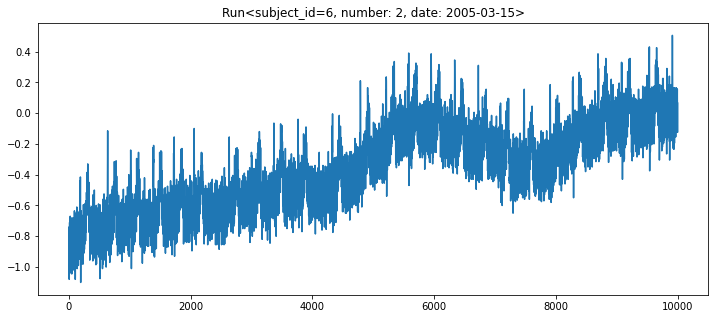

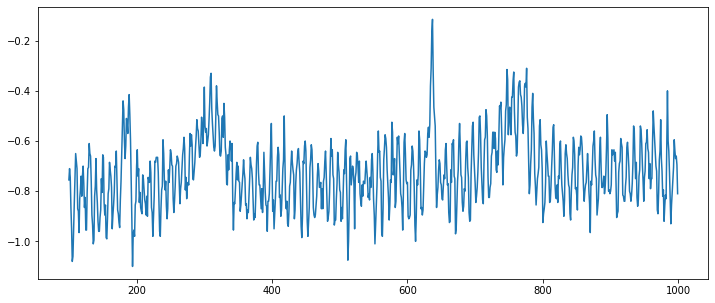

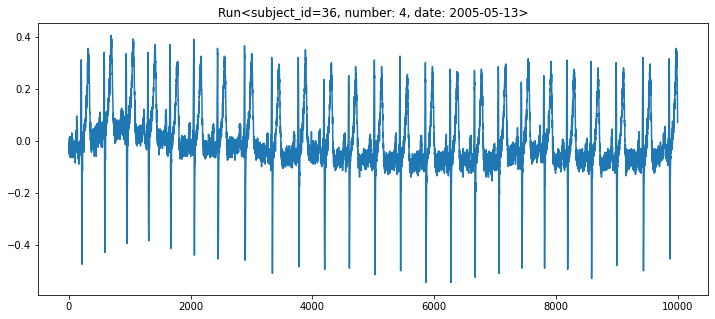

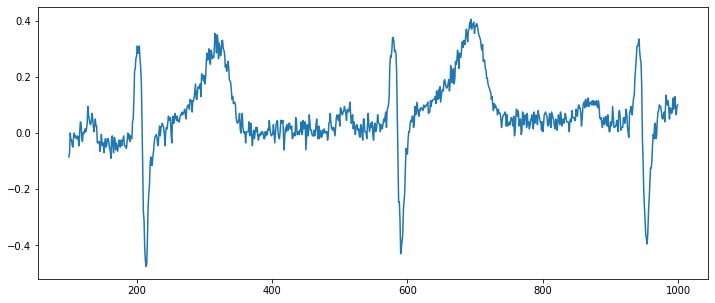

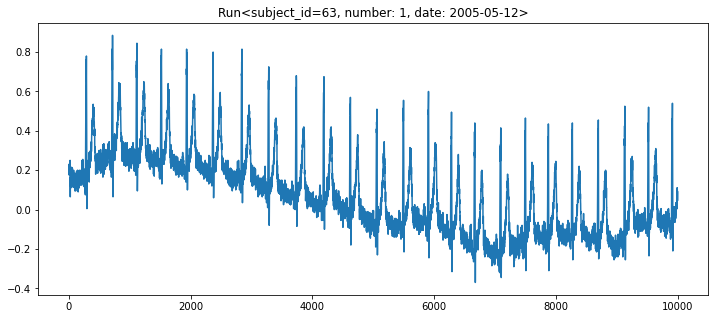

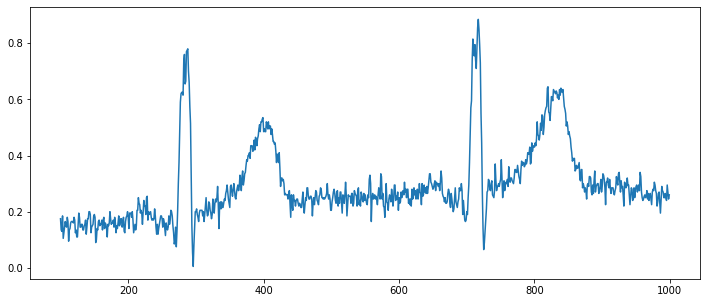

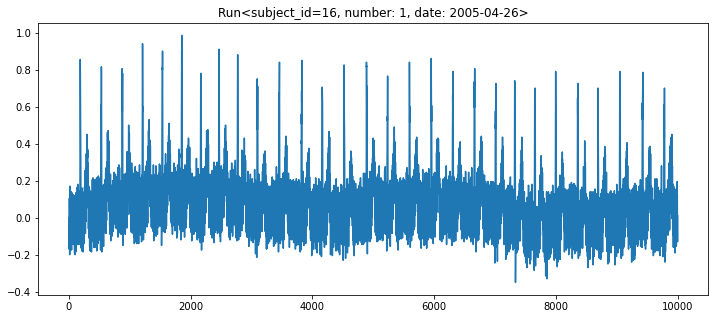

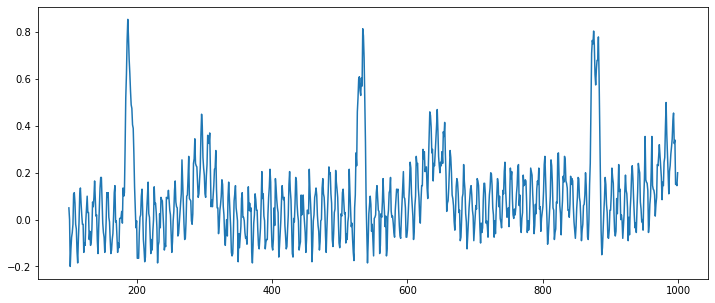

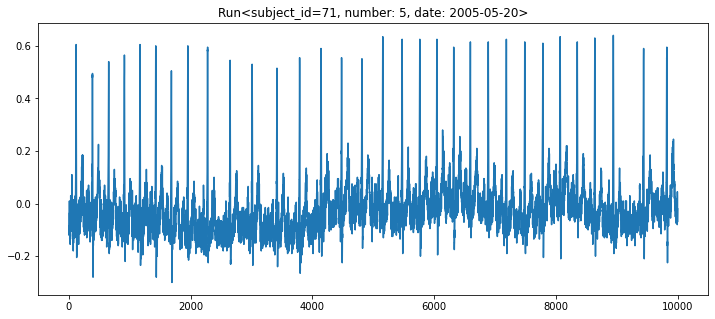

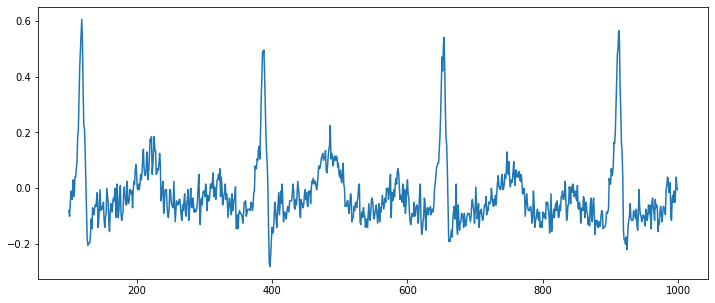

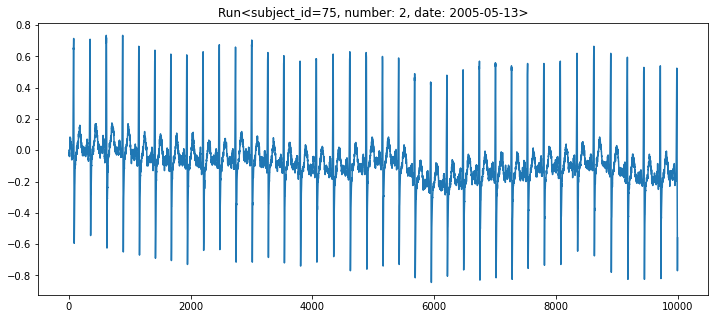

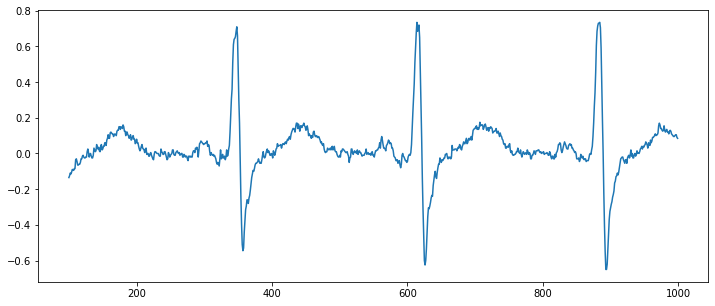

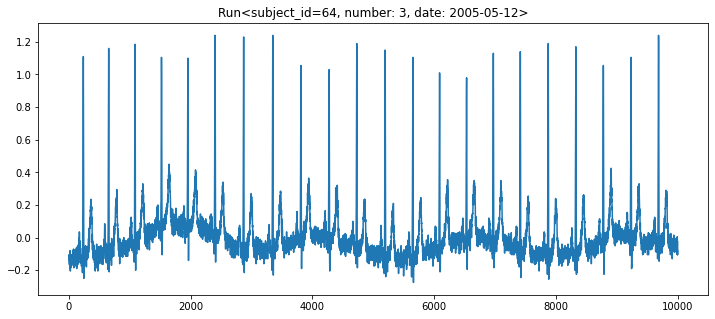

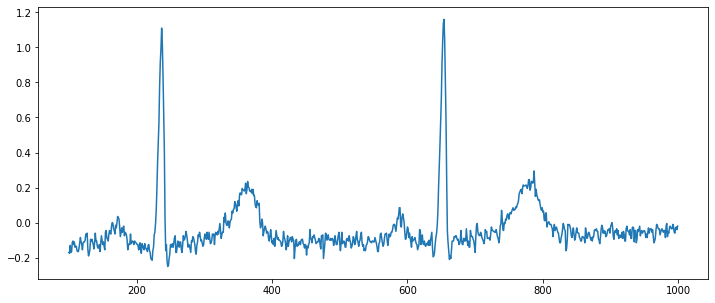

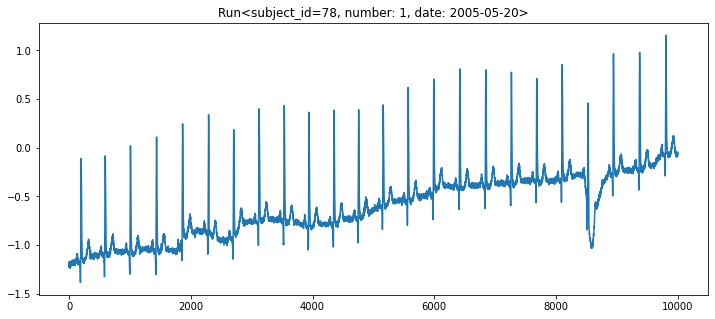

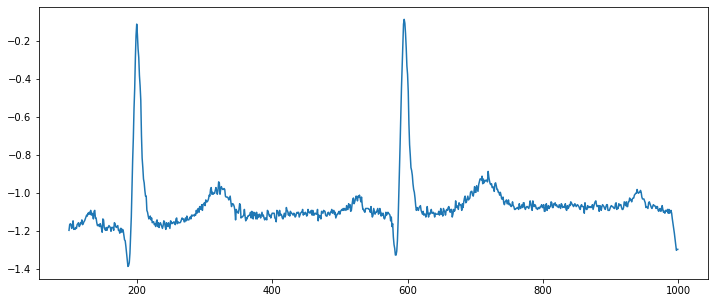

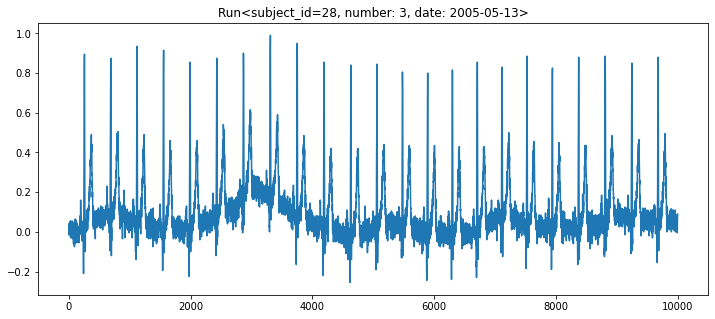

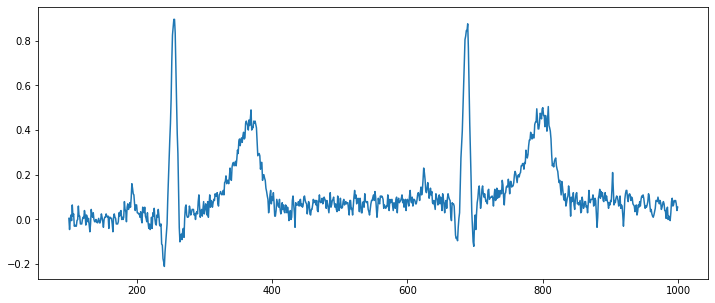

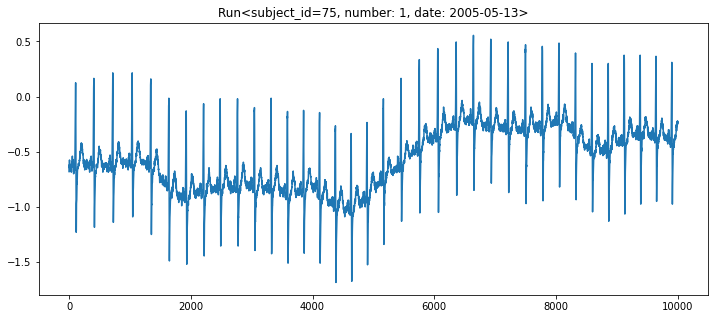

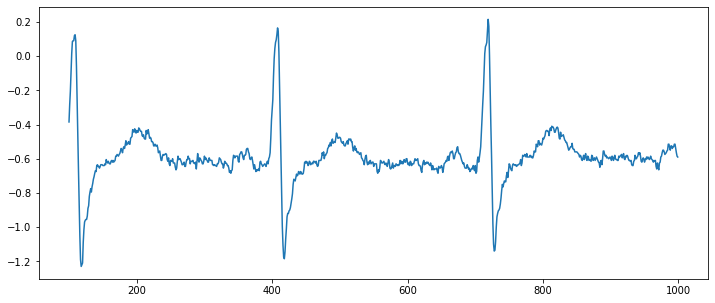

In [130]:
# let's plot
n_runs = 10
random_runs = get_random_runs(session, n=n_runs)

for run in random_runs:

    visualize_run(run)
    
    print("=" * 100)
    print("=" * 100)
    

# What jumps out in these plots?

1) Baseline Wander: periodicity is clear from the R waves, but the baseline itself has noticeable drift in many of the runs. Ideally, we would like each R wave to have the same horizontal reference point.  
2) The "zoomed in" views show high frequency oscilations around the peaks of interest. My untrained eye can pick out the ST-T "bump", but the jaggedness of the bump is, according to the textbook example, not of much use and would be nice to filter out.  
3) Anchor point: Some runs are centered around 0, some around -1.0. We'll want to rescale these for apples-to-apples comparison.

# Statistical summary of all runs

## 1. Outliers -- what are the mins and maxes of amplitudes in the whole dataset?

In [8]:
# we have 290 runs
session.query(Run).count()

290

Let's concatenate all the runs into a single dataframe so we can get statistical summaries of all:

In [10]:
dfs = []
for run in session.query(Run).all():
    df = run.raw
    df['subject_id'] = run.subject_id
    df['run_number'] = run.number
    df['run_id'] = f"{run.subject_id}_{run.number}"
    df['ts_index'] = df.index
    dfs.append(df)

master = pd.concat(dfs)

master.head()

,ecg_raw,subject_id,run_number,run_id,ts_index
0,-0.27,12,1,12_1,0
1,-0.23,12,1,12_1,1
2,-0.16,12,1,12_1,2
3,-0.15,12,1,12_1,3
4,-0.06,12,1,12_1,4


In [11]:
# we have some 2.9 million rows altogether
master.shape

(2900000, 5)

In [12]:
# group by run
run_group = master.groupby(['run_id'])['ecg_raw']

run_group.size().value_counts()

10000    290
Name: ecg_raw, dtype: int64

Looks like each of the 290 runs is 10000 lines. At 500Hz, this corresponds to **20 seconds** of recording.

# distribution of amplitudes per run

TL;DR: we'll want to do a Min/Max scaler to normalize amplitudes around a common baseline (0)

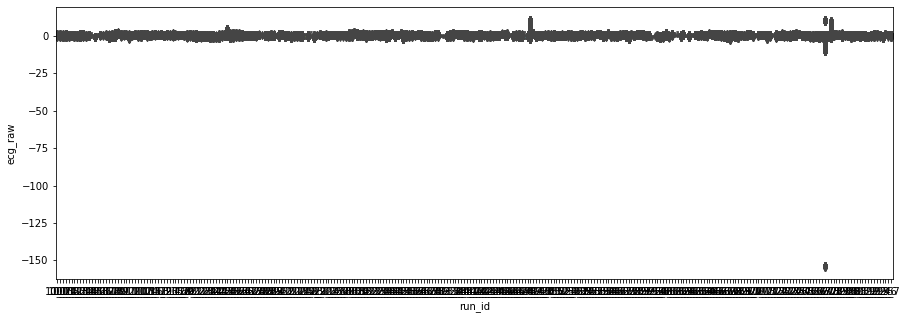

In [14]:
# box plot of each run to quickly find anomalies
plt.figure(figsize=(15, 5))
sns.boxplot(x='run_id', y='ecg_raw', data=master)

Out of curiosity: let's figure out which Run is way out of line on the bottom right

In [15]:
# min per run
run_mins = run_group.min()

# find run with global minimum amplitude
run_mins[run_mins == run_mins.min()]

run_id
76_2   -154.155
Name: ecg_raw, dtype: float64

**Subject 72, run 2** is the outlier

In [17]:
master[master['run_id'] == '76_2']['ecg_raw'].describe()

count    10000.000000
mean       -14.999309
std         45.963141
min       -154.155000
25%         -0.055000
50%          0.015000
75%          0.100000
max         10.745000
Name: ecg_raw, dtype: float64

This same run also has a very high max, so it's not just a maladjusted baseline that is the issue -- it appears to be suffering from some high-magnitude noise. Let's see if there are any others with similarly high standard deviations

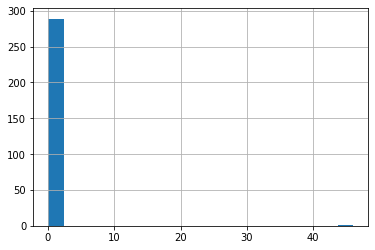

In [54]:
run_stds = run_group.std()

# distribution of standard deviations
run_stds.hist(bins=20)

In [55]:
# standard deviations are all pretty close to 1 already.
run_stds[run_stds > 2].sort_values()

run_id
47_2     2.351460
76_2    45.963141
Name: ecg_raw, dtype: float64

It's pretty much just run 76_2 that has a huge standard dev (46). The second largest is 2.4, and the rest are much closer to 0. 

Since the problem doesn't seem to affect a lot of runs, we'll take care of the more prevalent issues of 
1. denoising / filtering high and low frequencies
2. smoothing, and
3. removing baseline wandering


# Filtering Frequencies

In [57]:
# zooming in in just the max amplitudes now
# run_maxes = run_group.max()

# run_maxes[run_maxes > 4]

# run_maxes.hist(bins=100)

# run_group.mean().hist(bins=100)

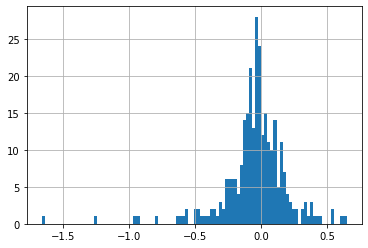

In [25]:
run_group.median().hist(bins=100)

In [26]:
runs_per_subject = pd.read_sql("""
    select 
        subject_id,
        count(distinct number) as n_runs 
    from run 
    group by 1
""", con=session.bind)

In [28]:
runs_per_subject.n_runs.value_counts()

2     41
3     14
5     13
4      5
6      2
22     1
20     1
11     1
8      1
7      1
1      1
Name: n_runs, dtype: int64

i.e.   
2 subjects have 41 runs,  
3 subjects have 14 runs,  
5 subjects have 13 runs,  
...


### Appendix
Trying some other open-source tools for ECG analysis

In [30]:
from biosppy.signals import ecg

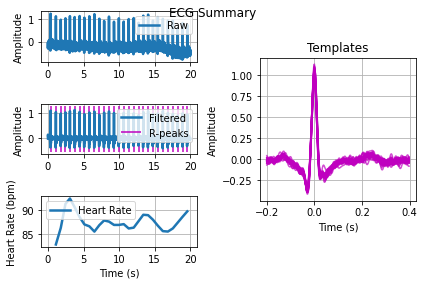

In [32]:
out = ecg.ecg(signal=tseries, sampling_rate=500)

In [33]:
ts, filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = out

In [36]:
ts

array([0.00000000e+00, 1.99980000e-03, 3.99960000e-03, ...,
       1.99920006e+01, 1.99940004e+01, 1.99960002e+01])

In [38]:
filtered.min()

-0.4147581485341231

In [39]:
filtered.max()

1.129710251124846

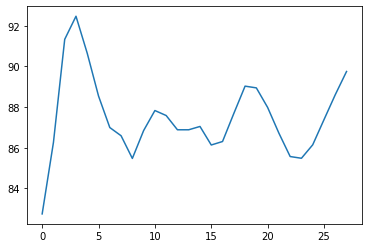

In [41]:
pd.Series(heart_rate).plot()